# Build Topology for Jellyfish

First, let us set host / switch and links:

In [4]:
host = 50
link = 8

Import necessay lib:

In [39]:
import os
import sys
import networkx as nx
import random
import matplotlib.pyplot as plt
import pickle
from itertools import islice

... and draw the topology!

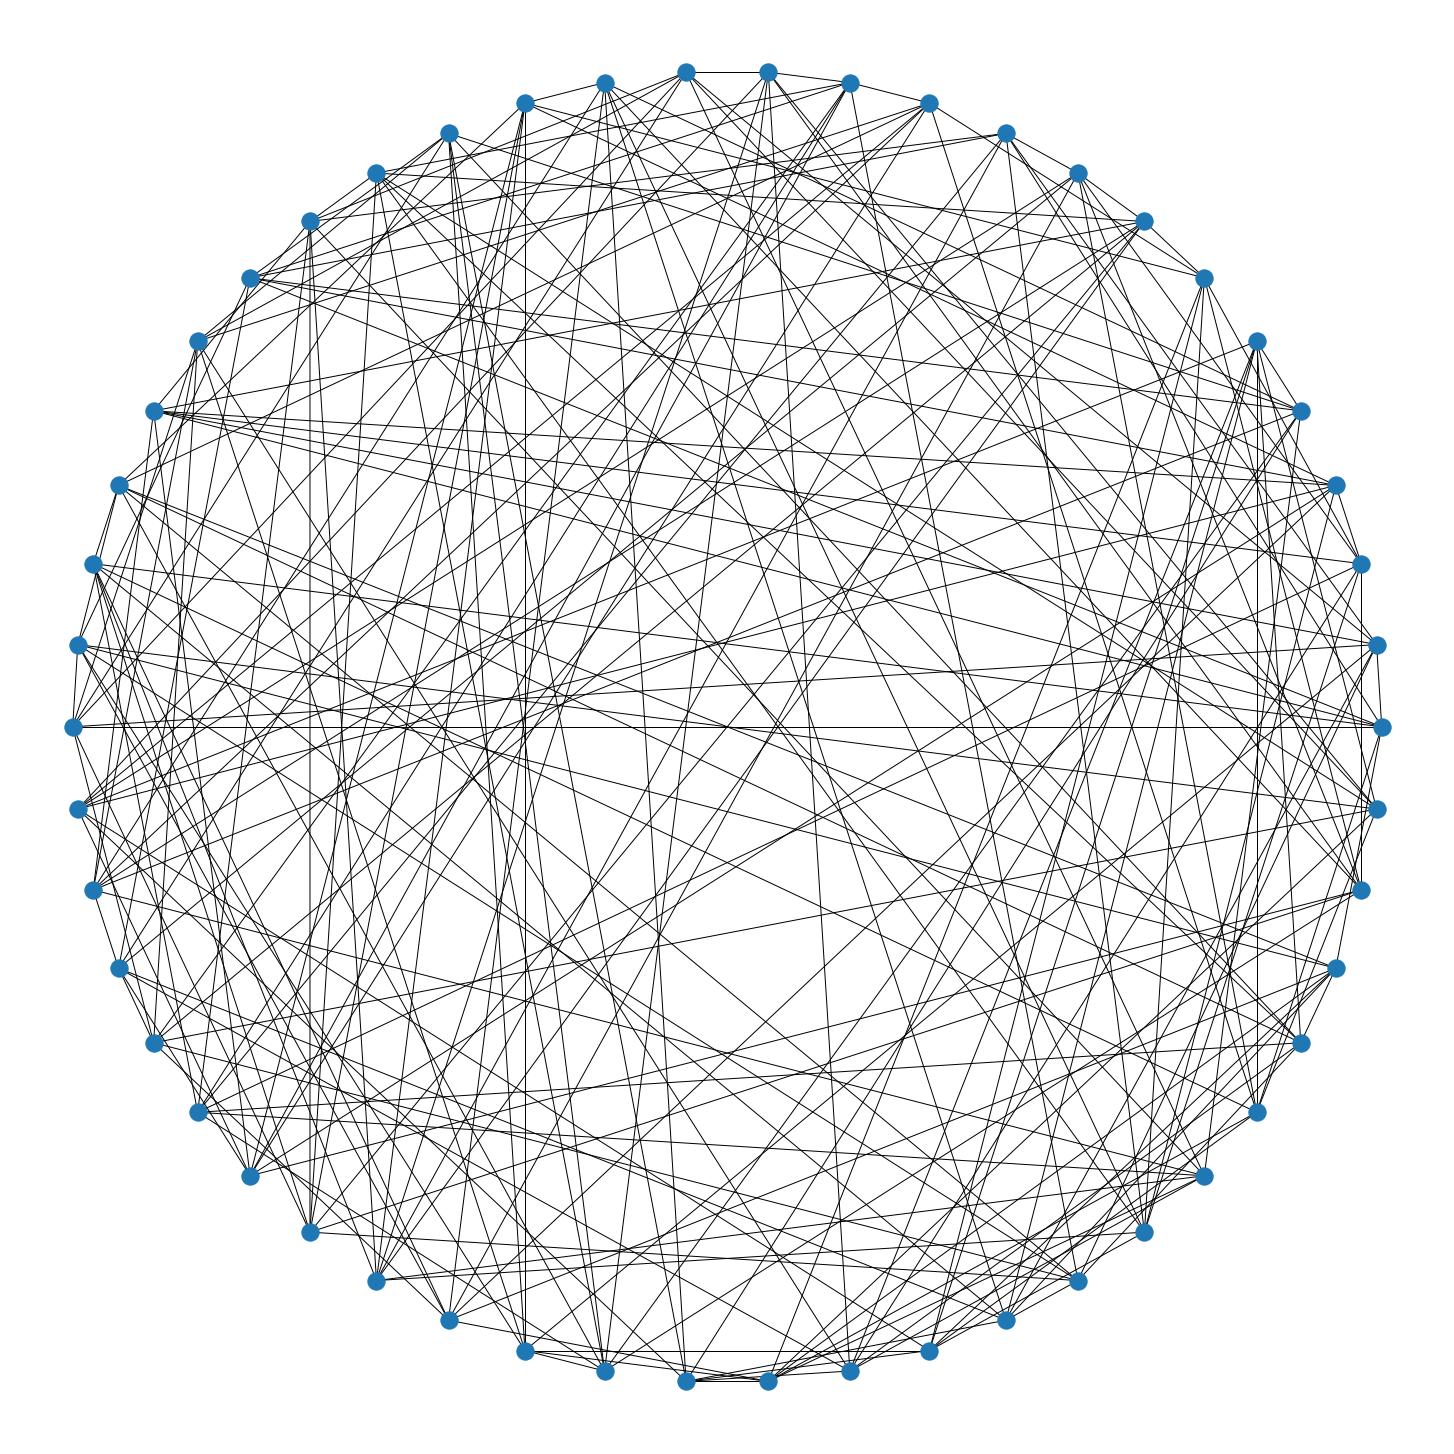

In [16]:
graph = nx.random_regular_graph(link, host)
plt.figure(1,figsize=(20,20)) 
nx.draw(graph, pos=nx.circular_layout(graph))
plt.show()

Write down the topology into file:

In [25]:
file_name = "rrg_%s_%s" % (link, host)
nx.write_adjlist(graph, file_name)
graph = nx.read_adjlist(file_name)

Caculate the ECMP paths:

In [32]:
def compute_ecmp_paths(graph, host):
    ecmp_paths = {}
    for a in range(host):
        ecmp_paths[(str(a), str(a))] = [[str(a)]]
        for b in range(a + 1, host):
            shortest_paths = nx.all_shortest_paths(graph, source=str(a), target=str(b))
            ecmp_paths[(str(a), str(b))] = [p for p in shortest_paths]
    return ecmp_paths


ecmp_paths = compute_ecmp_paths(graph, host)
ecmp_paths

{('0', '0'): [['0']],
 ('0', '1'): [['0', '1']],
 ('0', '2'): [['0', '2']],
 ('0', '3'): [['0', '22', '3']],
 ('0', '4'): [['0', '31', '4'], ['0', '37', '4']],
 ('0', '5'): [['0', '40', '5']],
 ('0', '6'): [['0', '40', '6']],
 ('0', '7'): [['0', '37', '7']],
 ('0', '8'): [['0', '31', '29', '8'],
  ['0', '37', '29', '8'],
  ['0', '2', '29', '8'],
  ['0', '33', '36', '8'],
  ['0', '33', '32', '8'],
  ['0', '33', '12', '8'],
  ['0', '37', '38', '8'],
  ['0', '2', '38', '8']],
 ('0', '9'): [['0', '40', '9'], ['0', '1', '9']],
 ('0', '10'): [['0', '22', '10'], ['0', '1', '10']],
 ('0', '11'): [['0', '33', '11'], ['0', '22', '11']],
 ('0', '12'): [['0', '33', '12']],
 ('0', '13'): [['0', '48', '28', '13'],
  ['0', '22', '28', '13'],
  ['0', '31', '25', '13'],
  ['0', '33', '25', '13'],
  ['0', '37', '25', '13'],
  ['0', '31', '27', '13'],
  ['0', '22', '27', '13'],
  ['0', '37', '27', '13'],
  ['0', '33', '11', '13'],
  ['0', '22', '11', '13'],
  ['0', '40', '5', '13'],
  ['0', '40', '6', '1

Save ECMP path into file:

In [36]:
def save_obj(obj, name):
    with open('pickled_routes/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
save_obj(ecmp_paths, "ecmp_%s" % (file_name))

Caculate k shortest paths:

In [45]:
def compute_k_shortest_paths(graph, n, k=8):
    all_ksp = {}
    for a in range(n):
        all_ksp[(str(a), str(a))] = [[str(a)]]
        for b in range(a + 1, n):
            ksp = list(islice(nx.shortest_simple_paths(graph, source=str(a), target=str(b)), k))
            all_ksp[(str(a), str(b))] = ksp
    return all_ksp


all_ksp = compute_k_shortest_paths(graph, host)
save_obj(ecmp_paths, "ecmp_%s" % (file_name))
all_ksp

{('0', '0'): [['0']],
 ('0', '1'): [['0', '1'],
  ['0', '48', '1'],
  ['0', '31', '23', '1'],
  ['0', '40', '19', '1'],
  ['0', '22', '10', '1'],
  ['0', '40', '9', '1'],
  ['0', '2', '19', '1'],
  ['0', '2', '24', '1']],
 ('0', '2'): [['0', '2'],
  ['0', '48', '43', '2'],
  ['0', '31', '23', '2'],
  ['0', '33', '35', '2'],
  ['0', '31', '29', '2'],
  ['0', '40', '43', '2'],
  ['0', '37', '38', '2'],
  ['0', '40', '19', '2']],
 ('0', '3'): [['0', '22', '3'],
  ['0', '48', '43', '3'],
  ['0', '31', '25', '3'],
  ['0', '48', '20', '3'],
  ['0', '33', '25', '3'],
  ['0', '40', '43', '3'],
  ['0', '37', '25', '3'],
  ['0', '1', '41', '3']],
 ('0', '4'): [['0', '31', '4'],
  ['0', '37', '4'],
  ['0', '31', '29', '4'],
  ['0', '33', '37', '4'],
  ['0', '37', '29', '4'],
  ['0', '22', '15', '4'],
  ['0', '2', '29', '4'],
  ['0', '22', '42', '4']],
 ('0', '5'): [['0', '40', '5'],
  ['0', '48', '20', '5'],
  ['0', '31', '23', '5'],
  ['0', '1', '41', '5'],
  ['0', '2', '23', '5'],
  ['0', '1', 

And caculate the non-overlapping paths:

In [50]:

def reset_weight(graph, n):
    for u, v, a in graph.edges(data=True):
        graph[u][v]["weight"] = 1
        graph[v][u]["weight"] = 1


def get_weight(graph, path):
    cnt = 0
    for hd in range(len(path) - 1):
        cnt += graph[str(path[hd])][str(path[hd + 1])]["weight"]
    return cnt


def compute_non_overlapping_paths(graph, n):
    paths = {}
    for a in range(n):
        paths[(str(a), str(a))] = [[str(a)]]
        for b in range(a + 1, n):
            reset_weight(graph, n)
            while True:
                shortest_path = nx.shortest_path(graph, source=str(a), target=str(b), weight="weight")
                if get_weight(graph, shortest_path) > 100000:
                    break
                if (str(a), str(b)) not in paths:
                    paths[(str(a), str(b))] = [shortest_path]
                else:
                    paths[(str(a), str(b))].append(shortest_path)

                for hd in range(len(shortest_path) - 1):
                    graph[str(shortest_path[hd])][str(shortest_path[hd + 1])]["weight"] += 100000
                    graph[str(shortest_path[hd + 1])][str(shortest_path[hd])]["weight"] += 100000

    return paths


non_overlapping = compute_non_overlapping_paths(graph, host)
save_obj(non_overlapping, "unique_%s" % (file_name))
non_overlapping

{('0', '0'): [['0']],
 ('0', '1'): [['0', '1'],
  ['0', '48', '1'],
  ['0', '31', '23', '1'],
  ['0', '40', '19', '1'],
  ['0', '22', '10', '1'],
  ['0', '2', '24', '1'],
  ['0', '33', '36', '9', '1'],
  ['0', '37', '25', '3', '41', '1']],
 ('0', '2'): [['0', '2'],
  ['0', '48', '43', '2'],
  ['0', '31', '23', '2'],
  ['0', '33', '35', '2'],
  ['0', '40', '19', '2'],
  ['0', '37', '38', '2'],
  ['0', '1', '24', '2'],
  ['0', '22', '15', '4', '29', '2']],
 ('0', '3'): [['0', '22', '3'],
  ['0', '48', '43', '3'],
  ['0', '31', '25', '3'],
  ['0', '37', '7', '3'],
  ['0', '1', '41', '3'],
  ['0', '2', '24', '3'],
  ['0', '33', '36', '46', '3'],
  ['0', '40', '43', '20', '3']],
 ('0', '4'): [['0', '31', '4'],
  ['0', '37', '4'],
  ['0', '22', '15', '4'],
  ['0', '2', '29', '4'],
  ['0', '48', '28', '21', '4'],
  ['0', '33', '36', '46', '4'],
  ['0', '40', '19', '30', '4'],
  ['0', '1', '41', '42', '4']],
 ('0', '5'): [['0', '40', '5'],
  ['0', '48', '20', '5'],
  ['0', '31', '23', '5'],
  